In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import least_squares

## Load and Manipulate Data

In [2]:
# Load INS data
ins_data = pandas.read_csv('csv/2-vectornav-ins.csv')
ins_data = ins_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
ins_data['time'] = pandas.to_datetime(ins_data['time'])
ins_data['time'] = (ins_data['time'] - ins_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
ins_data = ins_data.set_index('time')

# Load IMU Data
imu_data = pandas.read_csv('csv/2-vectornav-imu.csv') 
imu_data = imu_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
imu_data['time'] = pandas.to_datetime(imu_data['time'])
imu_data['time'] = (imu_data['time'] - imu_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
imu_data = imu_data.set_index('time')

# Load Pacmod Speed Data
# pacmod parsed_txt/vehicle_speed is gets corrupt rows, so we will use as_tx/vehicle_speed
pacmod_speed = pandas.read_csv('csv/2-pacmod-as_tx-vehicle_speed.csv')
pacmod_speed['time'] = pandas.to_datetime(pacmod_speed['time'])
pacmod_speed['time'] = (pacmod_speed['time'] - pacmod_speed['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_speed['.data'] = pacmod_speed['.data']*2.237 # Correction from parsed_txt/vehicle_speed to as_tx/vehicle_speed
pacmod_speed = pacmod_speed.set_index('time')

# Load Pacmod Steer Data
pacmod_steer = pandas.read_csv('csv/2-pacmod-parsed_tx-steer_rpt.csv')
pacmod_steer = pacmod_steer.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
pacmod_steer['time'] = pandas.to_datetime(pacmod_steer['time'])
pacmod_steer['time'] = (pacmod_steer['time'] - pacmod_steer['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_steer = pacmod_steer.set_index('time')

## Steering Ratio Estimation

In order to estimate the steering ratio, the following script iterates over multiple simulations, with a starting steering ratio estimated by measuring the angular offsets of the steering wheel and the tires. With each iteration, the steering ratio is updated by the relative error of heading compared to the INS gyroscope.

In [3]:
wheelbase = 3.4 # Known from measurements
rate = 30       # Hz
SR   = 21       # Best first guess.

for ii in range(10):
    predicted_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading

    for steering,time in zip(pacmod_steer['.manual_input'],pacmod_steer.index):    
        V = pacmod_speed.iloc[pacmod_speed.index.get_loc(time,method='nearest')]['.data']
        prediction = predicted_yaw[-1] - (V/wheelbase)*np.tan(steering/SR)/rate # updated equation. 
        prediction = (prediction + np.pi) % (2* np.pi) - np.pi # Wrap to pi
        predicted_yaw.append(prediction)

    SR = SR * (predicted_yaw[-1] + 7 * np.pi) / (ins_data.iloc[-1,7] * np.pi/180 + 7 * np.pi)


In [4]:
# Simulate one final time to plot results

predicted_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading

for steering,time in zip(pacmod_steer['.manual_input'],pacmod_steer.index):    
    V = pacmod_speed.iloc[pacmod_speed.index.get_loc(time,method='nearest')]['.data']
    prediction = predicted_yaw[-1] - (V/wheelbase)*np.tan(steering/SR)/rate # updated equation. 
    prediction = (prediction + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    predicted_yaw.append(prediction)

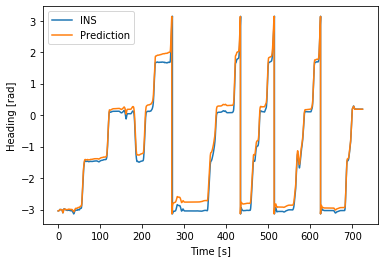

Steering Ratio: 22.17144334821909


In [5]:
# Plotting 

plt.figure()
plt.plot(ins_data.index.values,ins_data['.RPY.z'] * np.pi/180,label='INS') # plot yaw
plt.plot(pacmod_steer.index,predicted_yaw[0:-1],label='Prediction')
plt.xlabel('Time [s]')
plt.ylabel('Heading [rad]')
plt.legend()
plt.show();
print('Steering Ratio: ' + str(SR))

## IMU Misalignment Estimation

To estimate the misalignment of the IMU, since the route taken by the golfcart was a loop, the mean acceleartion in the x and y directions should be zero. However, due to misalignment of the IMU, there is a bias due to gravity. Taking the average values, it is possible to estimate the correction rotation matrix. The position error is minimized using non-linear least squares.

In [3]:
ax_bar = np.mean(imu_data['.Accel.x'])
ay_bar = np.mean(imu_data['.Accel.y'])
az_bar = np.mean(imu_data['.Accel.z'])
a = np.array([[ax_bar], [ay_bar], [az_bar]])
g = np.array([[0.0], [0.0], [-9.81]])

misa = 2.0*(np.matmul(a+g, (a+g).T))/(np.matmul((a+g).T,(a+g)))-np.identity(3)
print('IMU Misalignment Initial Guess:')
print(misa)

IMU Misalignment Initial Guess:
[[-9.99907436e-01  1.73684264e-05  1.36058318e-02]
 [ 1.73684264e-05 -9.99996741e-01  2.55296325e-03]
 [ 1.36058318e-02  2.55296325e-03  9.99904177e-01]]


In [4]:
# Residual function for Least Squares calculation

def residual_func(x):
    x_pos  = 0
    y_pos  = 0
    vx = 0
    vy = 0

    dt = 0.02

    misa = np.array([[1, x[3], x[5]],[x[3], 1, x[4]],[x[5], x[4], 1]])
    
    for ii in range(len(imu_data)-1):

        ax = imu_data.iloc[ii,6] - x[0] 
        ay = imu_data.iloc[ii,7] - x[1]
        az = imu_data.iloc[ii,8] - x[2]
        V  = np.array([[ax],[ay],[az]])
        A  = np.matmul(misa, V)

        x_pos += dt**2 / 2 * A[0] + dt * vx
        y_pos += dt**2 / 2 * A[1] + dt * vy
        vx    += dt * A[0]
        vy    += dt * A[1]

    return np.concatenate([x_pos, y_pos])

In [5]:
# Run Least Squares
x0 = np.array([0, 0, 0, misa[0,1], misa[1,2], misa[0,2]])
opt = least_squares(residual_func, x0)

In [7]:
# Run simulation with results 

x  = 0
y  = 0
vx = 0
vy = 0
pos_x = np.array([])
pos_y = np.array([])

x_raw  = 0
y_raw  = 0
vx_raw = 0
vy_raw = 0
pos_x_raw = np.array([])
pos_y_raw = np.array([])

t     = np.array([])
dt = 0.02

misa = np.array([[1, opt.x[3], opt.x[5]],[opt.x[3], 1, opt.x[4]],[opt.x[5], opt.x[4], 1]])

for ii in range(len(imu_data)-1):

    ax = imu_data.iloc[ii,6] - opt.x[0]
    ay = imu_data.iloc[ii,7] - opt.x[1]
    az = imu_data.iloc[ii,8] - opt.x[2]
    V  = np.array([[ax],[ay],[az]])
    A  = np.matmul(misa, V)

    x  += dt**2 / 2 * A[0] + dt * vx
    y  += dt**2 / 2 * A[1] + dt * vy
    vx += dt * A[0]
    vy += dt * A[1]
    
    pos_x = np.append(pos_x, x)
    pos_y = np.append(pos_y, y)
    
    x_raw  += dt**2 / 2 * imu_data.iloc[ii,6] + dt * vx_raw
    y_raw  += dt**2 / 2 * imu_data.iloc[ii,7] + dt * vy_raw
    vx_raw += dt * imu_data.iloc[ii,6]
    vy_raw += dt * imu_data.iloc[ii,7]
    
    pos_x_raw = np.append(pos_x_raw, x_raw)
    pos_y_raw = np.append(pos_y_raw, y_raw)
    
    t     = np.append(t, imu_data.iloc[ii,2] - 1266945082.0)


Estimated Error Terms

X Bias: -0.0026683898125025923
Y Bias: -0.000956410201558852
Z Bias: -5.772309828229052e-05

Misalignment:
[[ 1.00000000e+00 -2.82526466e-04 -1.24647919e-02]
 [-2.82526466e-04  1.00000000e+00 -6.78931811e-03]
 [-1.24647919e-02 -6.78931811e-03  1.00000000e+00]]


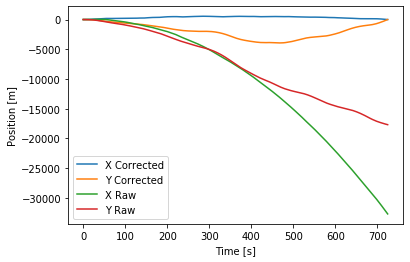

In [8]:
print('Estimated Error Terms\n')
print('X Bias: ' + str(opt.x[0]))
print('Y Bias: ' + str(opt.x[1]))
print('Z Bias: ' + str(opt.x[2]))
print('\nMisalignment:')
print(misa)

plt.plot(t, pos_x, t, pos_y, t, pos_x_raw, t, pos_y_raw);
plt.legend(['X Corrected', 'Y Corrected', 'X Raw', 'Y Raw']);
plt.xlabel('Time [s]');
plt.ylabel('Position [m]');